# 2D Histogram Tutorial

This notebook shows an example of how to use the `Hist2dQuadTree` class in `astroQTpy`.

### Simple 2D Gaussian

First, we'll create some mock data drawn from two indepedent normal distributions.

In [1]:
import numpy as np

N_samples = 10_000
x = np.random.normal(0, 1.0, N_samples)
y = np.random.normal(0, 1.0, N_samples)

Now import `Hist2dQuadTree` from the quadtree module in `astroQTpy` and create a new instance.

In [2]:
from astroqtpy.quadtree import Hist2dQuadTree

In [3]:
guassian_2d_histogram = Hist2dQuadTree(
    -5, 5, -5, 5,
    N_points=10,  # subdivide grid if node has more than this number of points...
    max_depth=6   # ...until the quadtree reaches this depth.
)

Now add the fake data to the quadtree object.

In [4]:
guassian_2d_histogram.add_data(x, y)

Plot it!

In [5]:
import matplotlib.pyplot as plt

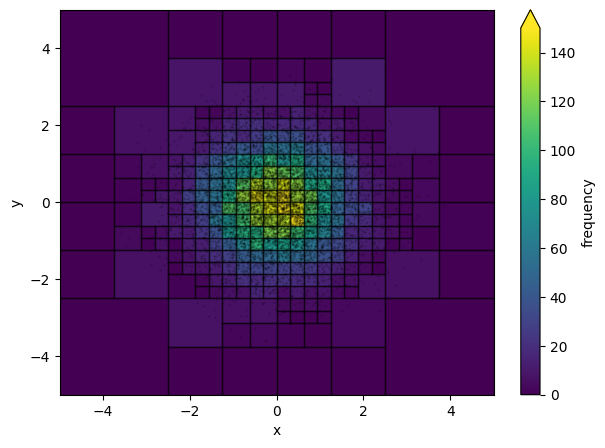

In [6]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

# plot data
ax.scatter(x, y, marker='.', s=1, c='k', alpha=0.2, zorder=99)

# plot the quadtree
hist2d = guassian_2d_histogram.draw_tree(ax, cmap='viridis', vmin=0, vmax=150)
plt.colorbar(hist2d, ax=ax, label='frequency', extend='max')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

### Gaia H-R Diagram

As an example of something more specific to astronomy, let's make an HRD using some Gaia data and `astroQTpy`.

First, we'll need to pull some stellar data from the Gaia archive. We can do that with `astroquery`.

In [7]:
from astroquery.gaia import Gaia

In [8]:
import time

def get_gaia_query(q):
    start = time.time()
    job = Gaia.launch_job_async(q)
    print(f"Total time: {time.time()-start:0.2f} sec")
    return job.get_results()

For this example, we'll keep our query simple. Let's just take the first 10,000 sources from the `astrophysical_parameters` table that have calculated luminosity, Teff, mass, and logg.

In [9]:
my_query = """
    SELECT TOP 10000 log10(lum_flame) AS log_lum,
        log10(teff_gspphot) AS log_teff,
        mass_flame AS mass,
        logg_gspphot AS log_g
    FROM gaiadr3.astrophysical_parameters
    WHERE lum_flame IS NOT NULL
        AND teff_gspphot IS NOT NULL
        AND mass_flame IS NOT NULL
        AND logg_gspphot IS NOT NULL
"""

In [10]:
# run query and print first 5 rows
gaia_results = get_gaia_query(my_query)
gaia_results[:5]

INFO: Query finished. [astroquery.utils.tap.core]
Total time: 3.07 sec


log_lum,log_teff,mass,log_g
,,solMass,log(cm.s**-2)
float64,float64,float32,float32
1.2749642400672603,3.6923804426660096,1.7511332,3.0866
-0.15209091918954543,3.759134754558573,0.9997815,3.8079
0.07155341905131725,3.74890517466525,0.9144622,4.3056
-1.1327641494248981,3.5804863065072805,0.554074,4.815
-0.5058447747626346,3.677801592462263,0.7655453,4.6798


Let's plot the Gaia data on an H-R Diagram.

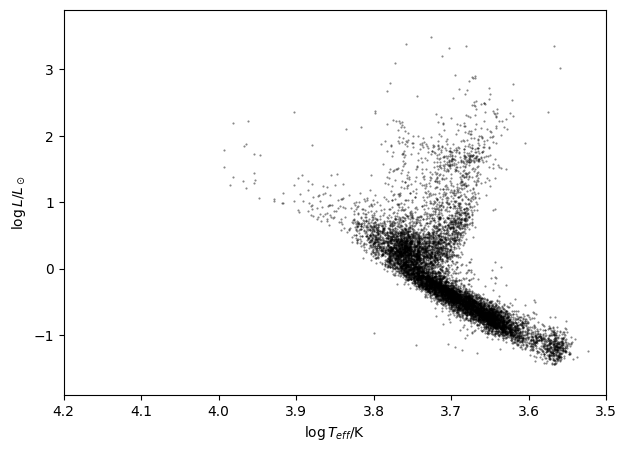

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim(3.5, 4.2)
ax.set_ylim(-1.9, 3.9)

ax.scatter(gaia_results['log_teff'], gaia_results['log_lum'], marker='.', s=1, c='k', alpha=0.5)
ax.set_xlabel('$\log T_{eff}$/K')
ax.set_ylabel('$\log L / L_\odot$')

ax.invert_xaxis()

Now we can use an `astroQTpy` quadtree to resctructure the data and create some useful visualizations. Let's go ahead and import the `Hist2dQuadTree` class and create a new instance, like we did before. Then, we'll add the Gaia data.

In [12]:
hrd_2d_histogram = Hist2dQuadTree(
    3.5, 4.2, -1.9, 3.9,
    N_points=5,   # subdivide grid if node has more than this number of points...
    max_depth=8   # ...until the quadtree reaches this depth.
)

# add data
hrd_2d_histogram.add_data(gaia_results['log_teff'].value.data, gaia_results['log_lum'].value.data)

First, let's plot the data and quadtree without shading in the nodes (the plot can start looking a bit busy depending on the maximum depth, number of points per node, etc.).

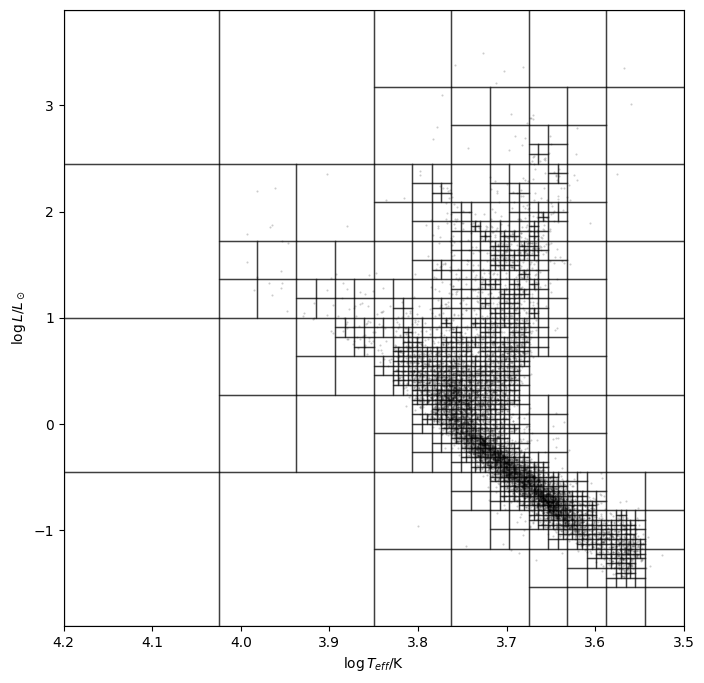

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(3.5, 4.2)
ax.set_ylim(-1.9, 3.9)

# plot data
ax.scatter(gaia_results['log_teff'], gaia_results['log_lum'], marker='.', s=1, c='k', alpha=0.2, zorder=99)

# plot the quadtree
hist2d = hrd_2d_histogram.draw_tree(ax, show_colors=False, cmap='viridis', vmin=0)
ax.set_xlabel('$\log T_{eff}$/K')
ax.set_ylabel('$\log L / L_\odot$')

ax.invert_xaxis()

plt.show()

Now let's visualize the HRD a slightly different way, this time turning back on the colors, but removing the node borders and data points. This time we get a plot that looks a bit cleaner!

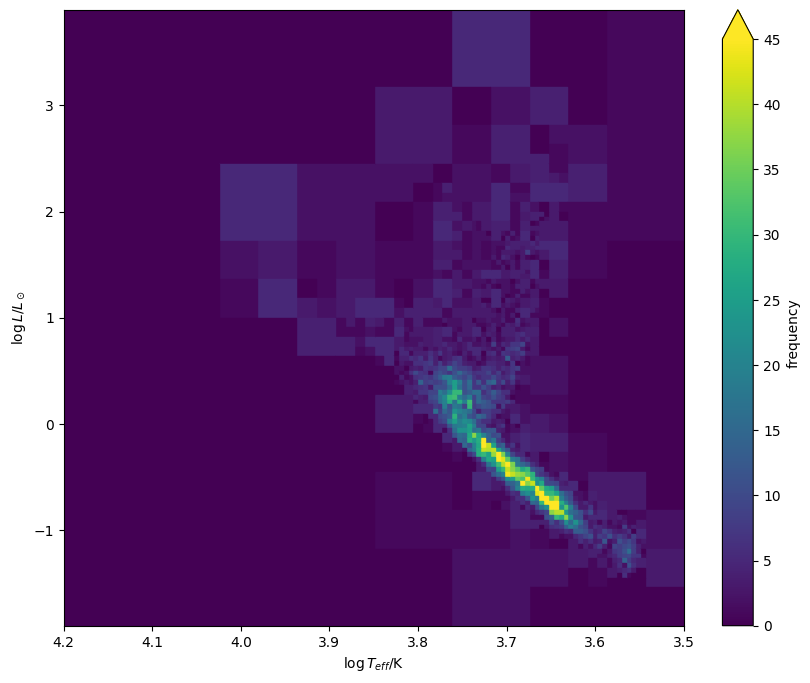

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3.5, 4.2)
ax.set_ylim(-1.9, 3.9)

# plot the quadtree
hist2d = hrd_2d_histogram.draw_tree(ax, show_lines=False, cmap='viridis', vmin=0, vmax=45)
plt.colorbar(hist2d, ax=ax, label='frequency', extend='max')
ax.set_xlabel('$\log T_{eff}$/K')
ax.set_ylabel('$\log L / L_\odot$')

ax.invert_xaxis()

plt.show()

Instead of counting the frequency of points within each node, we can select different bin statistics to visualize useful quantities. For example, we can plot the average $\log g$ of stars within each grid cell. To do this, we just need to pass a third data array to the quadtree object and choose a node statistic.

In [15]:
hrd_2d_histogram = Hist2dQuadTree(
    3.5, 4.2, -1.9, 3.9,
    N_points=5,   # subdivide grid if node has more than this number of points...
    max_depth=8,  # ...until the quadtree reaches this depth.
    node_statistic='mean'
)

hrd_2d_histogram.add_data(
    gaia_results['log_teff'].value.data,
    gaia_results['log_lum'].value.data,
    gaia_results['log_g'].value.data
)

Let's plot the HRD again, this time showing the points and colors representing average $\log g$.

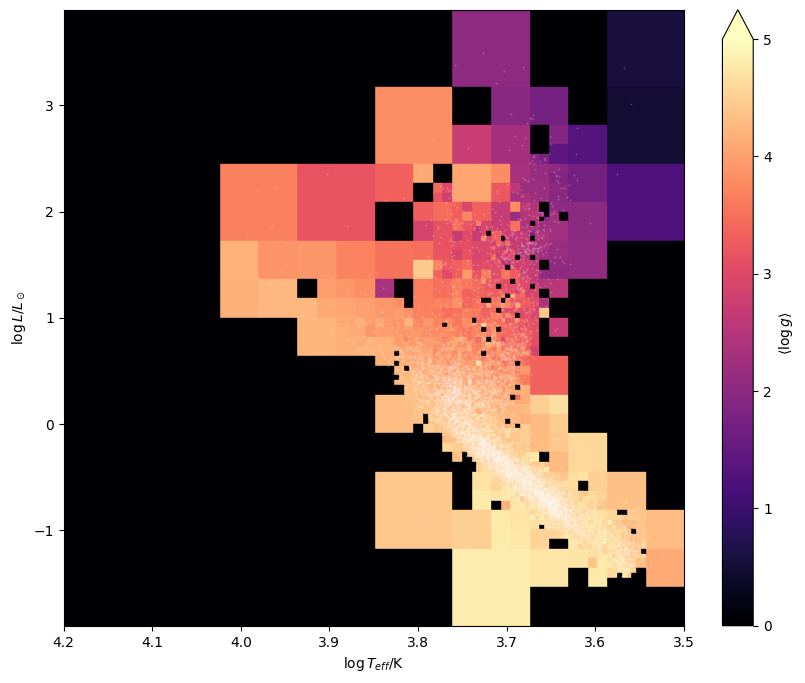

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3.5, 4.2)
ax.set_ylim(-1.9, 3.9)

# plot data
ax.scatter(gaia_results['log_teff'], gaia_results['log_lum'], c='w', marker='.', s=1, alpha=0.2, zorder=99)

# plot the quadtree
hist2d = hrd_2d_histogram.draw_tree(ax, show_lines=False, cmap='magma', vmin=0, vmax=5)
plt.colorbar(hist2d, ax=ax, label='$\langle \log g \\rangle$', extend='max')
ax.set_xlabel('$\log T_{eff}$/K')
ax.set_ylabel('$\log L / L_\odot$')

ax.invert_xaxis()

plt.show()